# Q3: AI 세율을 정책적으로 적용했을 때의 거시경제적 효과?

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit, differential_evolution
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from statsmodels.tsa.api import VAR

In [339]:
np.random.seed(42)
correlation_threshold = 0.45

file_path = "../data/master_data_by_category_clear.csv"
df = pd.read_csv(file_path)

In [340]:
China_df = df[df["Country"] == "China"].copy()
France_df = df[df["Country"] == "France"].copy()
USA_df = df[df["Country"] == "United States of America"].copy()
Germany_df = df[df["Country"] == "Germany"].copy()
Japan_df = df[df["Country"] == "Japan"].copy()
Korea_df = df[df["Country"] == "Korea"].copy()
UK_df = df[df["Country"] == "United Kingdom"].copy()

In [ ]:
def get_high_corr_vars(country_df):
    country_numeric_df = country_df.select_dtypes(include=[np.number]).drop(["GDP", "Year"], axis=1, errors="ignore")
    correlations = country_numeric_df.corrwith(country_df["GDP"]).dropna().abs()
    high_corr_vars = correlations[correlations > correlation_threshold].index.tolist()
    
    # 이 후 비교를 위해 GERD와 Patent Publications를 포함
    essential_vars = ["GERD", "Patent Publications", "Year"]
    for var in essential_vars:
        if var not in high_corr_vars and var in country_df.columns:
            high_corr_vars.append(var)
    
    return high_corr_vars


# 각 국가별 상관관계 높은 변수 찾기
China_high_corr_vars = get_high_corr_vars(China_df)
France_high_corr_vars = get_high_corr_vars(France_df)
USA_high_corr_vars = get_high_corr_vars(USA_df)
Germany_high_corr_vars = get_high_corr_vars(Germany_df)
Japan_high_corr_vars = get_high_corr_vars(Japan_df)
Korea_high_corr_vars = get_high_corr_vars(Korea_df)
UK_high_corr_vars = get_high_corr_vars(UK_df)

# 국가별 변수 저장
China_df = China_df[["Country", "Year", "GDP"] + China_high_corr_vars]
France_df = France_df[["Country", "Year", "GDP"] + France_high_corr_vars]
USA_df = USA_df[["Country", "Year", "GDP"] + USA_high_corr_vars]
Germany_df = Germany_df[["Country", "Year", "GDP"] + Germany_high_corr_vars]
Japan_df = Japan_df[["Country", "Year", "GDP"] + Japan_high_corr_vars]
Korea_df = Korea_df[["Country", "Year", "GDP"] + Korea_high_corr_vars]
UK_df = UK_df[["Country", "Year", "GDP"] + UK_high_corr_vars]

c:\workspace\2025oss-couscous\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [342]:
scaler = MinMaxScaler(feature_range=(0, 0.5))

def find_best_proxy(country_df, high_corr_vars):
    proxy_candidates = []
    
    for r in range(2, 4):
        for combo in combinations(high_corr_vars, r):
            valid_combo = [col for col in combo if col in country_df.columns]
            if len(valid_combo) == r:
                proxy_name = f"AI_Tax_Proxy_{'_'.join(valid_combo)}"
                df_scaled = scaler.fit_transform(country_df[valid_combo])
                country_df[proxy_name] = df_scaled.mean(axis=1)
                proxy_candidates.append(proxy_name)
    
    return proxy_candidates

China_proxy_candidates = find_best_proxy(China_df, China_high_corr_vars)
France_proxy_candidates = find_best_proxy(France_df, France_high_corr_vars)
USA_proxy_candidates = find_best_proxy(USA_df, USA_high_corr_vars)
Germany_proxy_candidates = find_best_proxy(Germany_df, Germany_high_corr_vars)
Japan_proxy_candidates = find_best_proxy(Japan_df, Japan_high_corr_vars)
Korea_proxy_candidates = find_best_proxy(Korea_df, Korea_high_corr_vars)
UK_proxy_candidates = find_best_proxy(UK_df, UK_high_corr_vars)

C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\4098189239.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  country_df[proxy_name] = df_scaled.mean(axis=1)
C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\4098189239.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  country_df[proxy_name] = df_scaled.mean(axis=1)
C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\4098189239.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [343]:
def find_best_model(country_df, proxy_candidates):
    best_degree = 1
    best_bic = np.inf
    best_proxy = None
    
    for proxy in proxy_candidates:
        X = country_df[[proxy]].values
        y = country_df["GDP"].values
        
        for d in range(2, 7):
            poly = PolynomialFeatures(degree=d)
            X_poly = poly.fit_transform(X)
            model = LinearRegression()
            model.fit(X_poly, y)
            y_pred = model.predict(X_poly)
            bic = len(y) * np.log(mean_squared_error(y, y_pred)) + d * np.log(len(y))
            
            if bic < best_bic:
                best_bic = bic
                best_degree = d
                best_proxy = proxy
    
    return best_degree, best_proxy

In [344]:
China_best_degree, China_best_proxy = find_best_model(China_df, China_proxy_candidates)
France_best_degree, France_best_proxy = find_best_model(France_df, France_proxy_candidates)
USA_best_degree, USA_best_proxy = find_best_model(USA_df, USA_proxy_candidates)
Germany_best_degree, Germany_best_proxy = find_best_model(Germany_df, Germany_proxy_candidates)
Japan_best_degree, Japan_best_proxy = find_best_model(Japan_df, Japan_proxy_candidates)
Korea_best_degree, Korea_best_proxy = find_best_model(Korea_df, Korea_proxy_candidates)
UK_best_degree, UK_best_proxy = find_best_model(UK_df, UK_proxy_candidates)

print(f"\n 최적 차수 및 Proxy\n")
print(f"China: {China_best_degree}, {China_best_proxy}")
print(f"France: {France_best_degree}, {France_best_proxy}")
print(f"USA: {USA_best_degree}, {USA_best_proxy}")
print(f"Germany: {Germany_best_degree}, {Germany_best_proxy}")
print(f"Japan: {Japan_best_degree}, {Japan_best_proxy}")
print(f"Korea: {Korea_best_degree}, {Korea_best_proxy}")
print(f"United Kingdom: {UK_best_degree}, {UK_best_proxy}")


 최적 차수 및 Proxy

China: 6, AI_Tax_Proxy_Business sophistication_GDP_per_capita_PPP_GERD
France: 6, AI_Tax_Proxy_GNI_per_capita_Internet Usage_Year
USA: 6, AI_Tax_Proxy_GDP_per_capita_PPP_Year
Germany: 6, AI_Tax_Proxy_WIPO Tax_Year
Japan: 6, AI_Tax_Proxy_GERD_Institutions
Korea: 6, AI_Tax_Proxy_Market sophistication_WIPO Tax_Year
United Kingdom: 6, AI_Tax_Proxy_General Revenue_Institutions_GERD


In [345]:
country_optimal_params = {}
country_optimal_taxes = {}

def laffer_curve(x, a, b, c):
    return a * x**2 + b * x + c


for country, country_df, best_degree, best_proxy in [
    ("China", China_df, China_best_degree, China_best_proxy),
    ("France", France_df, France_best_degree, France_best_proxy),
    ("USA", USA_df, USA_best_degree, USA_best_proxy),
    ("Germany", Germany_df, Germany_best_degree, Germany_best_proxy),
    ("Japan", Japan_df, Japan_best_degree, Japan_best_proxy),
    ("Korea", Korea_df, Korea_best_degree, Korea_best_proxy),
    ("UK", UK_df, UK_best_degree, UK_best_proxy),
]:
    X_proxy = country_df[[best_proxy]].values.flatten()
    y_gdp = country_df["GDP"].values

    if best_degree > 1:
        try:
            params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
            country_optimal_params[country] = params
        except RuntimeError:
            print(f"{country}: Curve Fitting 실패")
            continue
    else:
        params = [0, 0, y_gdp.mean()]
        country_optimal_params[country] = params

    def optimize_tax(tax_rate):
        return -laffer_curve(tax_rate, *params)

    bounds = [(0, 0.4)]
    opt_result = differential_evolution(optimize_tax, bounds, seed=42)
    optimal_tax = opt_result.x[0]

    country_optimal_taxes[country] = optimal_tax
    print(f"{country} 최적 AI 세율: {optimal_tax:.4f}")

China 최적 AI 세율: 0.0960
France 최적 AI 세율: 0.0960
USA 최적 AI 세율: 0.1149
Germany 최적 AI 세율: 0.0960
Japan 최적 AI 세율: 0.0960
Korea 최적 AI 세율: 0.0960
UK 최적 AI 세율: 0.0960


C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\2050474795.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\2050474795.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\2050474795.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\2050474795.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(laffer_curve, X_proxy, y_gdp, p0=[-0.5, 0.1, y_gdp.mean()])
C:\Users\joowo\AppData\Local\Temp\ipykernel_1576\2050474795.py:22: OptimizeWarning: Covariance of the parameters could n

In [346]:
best_proxy_dict = {
    "China": China_best_proxy,
    "France": France_best_proxy,
    "United States of America": USA_best_proxy,
    "Germany": Germany_best_proxy,
    "Japan": Japan_best_proxy,
    "Korea": Korea_best_proxy,
    "United Kingdom": UK_best_proxy
}
print(best_proxy_dict)

{'China': 'AI_Tax_Proxy_Business sophistication_GDP_per_capita_PPP_GERD', 'France': 'AI_Tax_Proxy_GNI_per_capita_Internet Usage_Year', 'United States of America': 'AI_Tax_Proxy_GDP_per_capita_PPP_Year', 'Germany': 'AI_Tax_Proxy_WIPO Tax_Year', 'Japan': 'AI_Tax_Proxy_GERD_Institutions', 'Korea': 'AI_Tax_Proxy_Market sophistication_WIPO Tax_Year', 'United Kingdom': 'AI_Tax_Proxy_General Revenue_Institutions_GERD'}


### GDP와 GERD, AI-Related Patent Publications 관계 분석

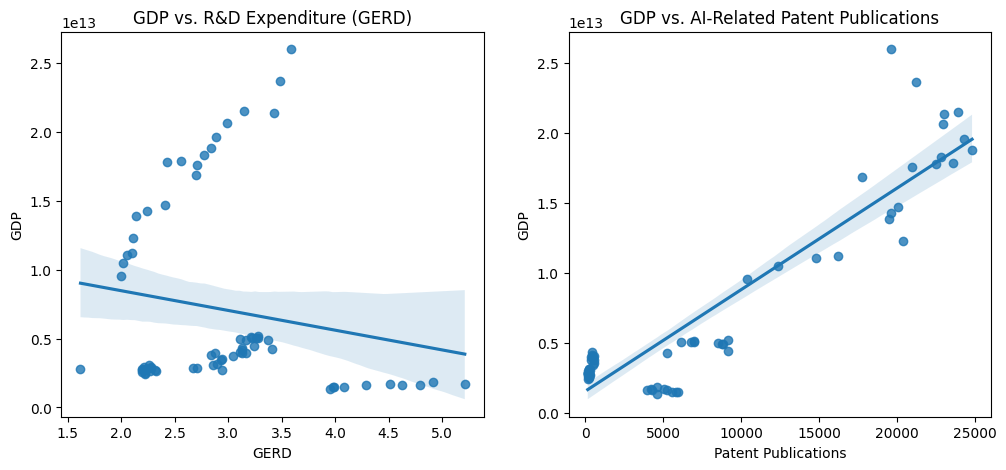

In [347]:
def analyze_gdp_rd_relationship(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.regplot(x=df["GERD"], y=df["GDP"], ax=axes[0])
    axes[0].set_title("GDP vs. R&D Expenditure (GERD)")

    sns.regplot(x=df["Patent Publications"], y=df["GDP"], ax=axes[1])
    axes[1].set_title("GDP vs. AI-Related Patent Publications")

    plt.show()

analyze_gdp_rd_relationship(df)

## 1. 반사실 분석 (Counterfactual Analysis)

- 현재 AI 세율이 없는 상황에서 최적 AI 세율이 적용되었을 경우 GDP 변화를 예측하는 반사실 분석 수행

In [348]:
def counterfactual_analysis(country, country_df, optimal_tax):
    best_proxy = best_proxy_dict.get(country, None)
    if best_proxy is None:
        return None

    X_proxy = country_df[[best_proxy]].values.flatten()
    y_gdp = country_df["GDP"].values

    params = country_optimal_params.get(country, None)
    if params is None:
        return None

    predicted_gdp = params[0] * optimal_tax**2 + params[1] * optimal_tax + params[2]
    actual_gdp_mean = np.mean(y_gdp)
    gdp_change = (predicted_gdp - actual_gdp_mean) / actual_gdp_mean * 100

    return gdp_change

In [349]:
country_gdp_changes = {
    country: counterfactual_analysis(country, country_df, country_optimal_taxes.get(country, None))
    for country, country_df in [
        ("China", China_df), ("France", France_df), ("USA", USA_df),
        ("Germany", Germany_df), ("Japan", Japan_df), ("Korea", Korea_df), ("UK", UK_df)
    ]
}
print(country_gdp_changes)

{'China': np.float64(4.398389627340844e-14), 'France': np.float64(7.749320331983593e-13), 'USA': None, 'Germany': np.float64(1.253301818627968e-13), 'Japan': np.float64(9.966090925753342e-14), 'Korea': np.float64(3.0599124792572204e-13), 'UK': None}


## 2. 합성 통제법 (Synthetic Control Method)
- 합성 통제법을 활용하여 AI 세율이 적용된 국가의 가상 데이터를 생성하고, 실제 데이터와 비교하여 GDP 변화 분석

In [350]:
def synthetic_control(country, country_df):
    predictors = country_df.drop(columns=["GDP", "Year", "Country"], errors="ignore")
    response = country_df["GDP"]

    model = Ridge(alpha=1.0)
    model.fit(predictors, response)
    synthetic_gdp = model.predict(predictors)

    return synthetic_gdp

In [351]:
synthetic_results = {
    country: synthetic_control(country, country_df)
    for country, country_df in [
        ("China", China_df), ("France", France_df), ("United States of America", USA_df),
        ("Germany", Germany_df), ("Japan", Japan_df), ("Korea", Korea_df), ("United Kingdom", UK_df)
    ]
}

## 3. 거시경제 시뮬레이션 (Macroeconomic Simulation)
- AI 세율 조정 시 거시경제 변수 변화율 시뮬레이션 (GDP, AI 투자, R&D 지출)

In [ ]:
def macroeconomic_simulation(country, country_df):
    model_data = country_df[["GDP", "GERD", "Patent Publications"]].dropna()
    if model_data.shape[0] < 5:
        return None
    model = VAR(model_data)
    results = model.fit(maxlags=2)
    # 5년 후 예측
    forecast = results.forecast(model_data.values[-2:], steps=5)
    forecast_df = pd.DataFrame(forecast, columns=["GDP", "GERD", "Patent Publications"])
    return forecast_df

In [353]:
macroeconomic_results = {
    country: macroeconomic_simulation(country, country_df)
    for country, country_df in [
        ("China", China_df), ("France", France_df), ("United States of America", USA_df),
        ("Germany", Germany_df), ("Japan", Japan_df), ("Korea", Korea_df), ("United Kingdom", UK_df)
    ]
}

c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsup

In [354]:
country_gdp_changes = {}
for country, country_df in [
    ("China", China_df), ("France", France_df), ("United States of America", USA_df),
    ("Germany", Germany_df), ("Japan", Japan_df), ("Korea", Korea_df), ("United Kingdom", UK_df)
]:
    actual_years = df[df["Country"] == country]["Year"]
    if actual_years.empty:
        continue
    actual_gdp = df[df["Country"] == country]["GDP"].iloc[-1]
    forecast_df = macroeconomic_results.get(country)
    if forecast_df is not None:
        forecast_gdp = forecast_df["GDP"].iloc[-1]
        change = (forecast_gdp - actual_gdp) / actual_gdp * 100
        country_gdp_changes[country] = change
    else:
        country_gdp_changes[country] = None

## 시각화
1) VAR 시뮬레이션 결과: macroeconomic_results
    -> key: 국가명, value: 예측 DataFrame( "GDP", "GERD", "Patent Publications" )
2) df: 전체 데이터프레임, 국가별로 실제 GDP와 Year 추출
3) country_gdp_changes: 각 국가의 GDP 변화율 (마지막 실제값 vs 마지막 예측값)

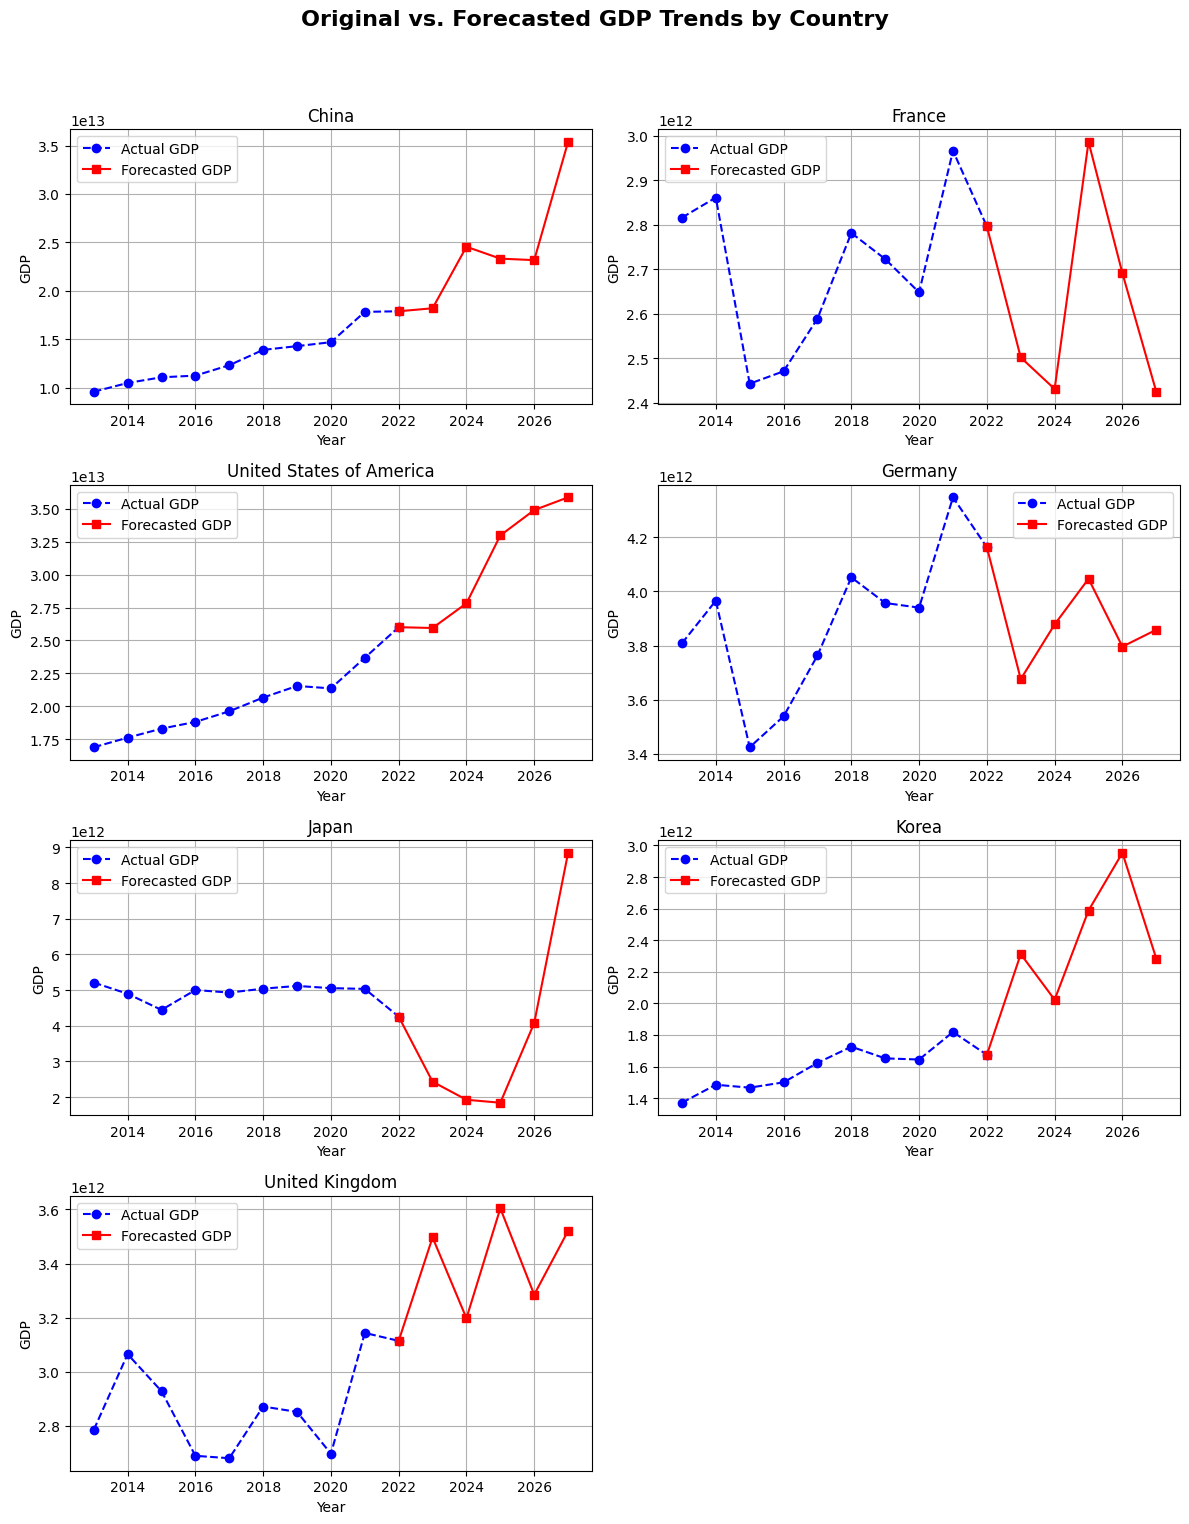

In [365]:
num_countries = len(macroeconomic_results)
valid_countries = [c for c, fdf in macroeconomic_results.items() if fdf is not None]
cols = 2
rows = (len(valid_countries) + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
fig.suptitle("Original vs. Forecasted GDP Trends by Country", fontsize=16, fontweight='bold')

if rows == 1 and len(valid_countries) == 1:
    # 서브플롯이 1개만 존재하는 경우 axes가 1차원일 수 있음 So, 2D로 처리
    axes = np.array([[axes]])

i = 0
for country in valid_countries:
    ax = axes[i // cols, i % cols]

    # 실제 GDP 데이터
    country_data = df[df["Country"] == country].copy()
    if country_data.empty:
        i += 1
        continue
    
    years_actual = country_data["Year"]
    gdp_actual = country_data["GDP"]
    
    # 마지막 연도(2022)
    last_year = years_actual.max()
    last_gdp = gdp_actual.iloc[-1]

    # 예측 GDP
    forecast_df = macroeconomic_results[country]
    gdp_forecast = forecast_df["GDP"]
    # 미래 연도 리스트
    future_years = list(range(last_year + 1, last_year + 1 + len(gdp_forecast)))
    
    # 두 시계열 이어주기기
    # x축: 연도, y축: GDP
    combined_years = [last_year] + future_years
    combined_gdp = [last_gdp] + list(gdp_forecast)
    
    # 실제 GDP 구간
    ax.plot(years_actual, gdp_actual, 
            label="Actual GDP", linestyle="--", marker="o", color="blue")
    # 예측 구간
    ax.plot(combined_years, combined_gdp, 
            label="Forecasted GDP", linestyle="-", marker="s", color="red")
    
    ax.set_title(f"{country}")
    ax.set_xlabel("Year")
    ax.set_ylabel("GDP")
    ax.legend()
    ax.grid(True)
    
    i += 1

# 빈 서브플롯 제거
if len(valid_countries) % cols != 0:
    for j in range(i, rows * cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### country_gdp_changes

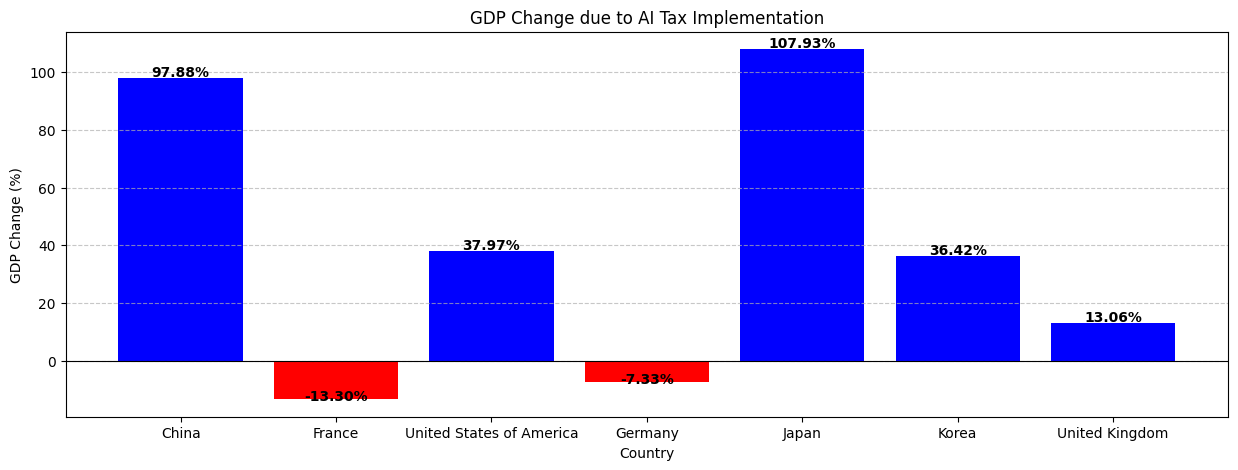

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
valid_changes = {k: v for k, v in country_gdp_changes.items() if v is not None}

bars = ax.bar(valid_changes.keys(), valid_changes.values(),
            color=["blue" if v >= 0 else "red" for v in valid_changes.values()])
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("GDP Change (%)")
ax.set_title("GDP Change due to AI Tax Implementation")
ax.set_xlabel("Country")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# 수치 표시 로직
for idx, (country, val) in enumerate(valid_changes.items()):
    ax.text(idx, val + (0.5 if val >= 0 else -0.5), f"{val:.2f}%", 
            ha="center", fontsize=10, fontweight="bold")

plt.show()

## 2. Synthetic Control 결과 시각화 (실제 GDP vs Synthetic GDP)
- synthetic_results: {국가: synthetic_gdp_array} 
- 각 국가의 실제 GDP 데이터는 각국의 DataFrame에서 "GDP"와 "Year" 열 사용

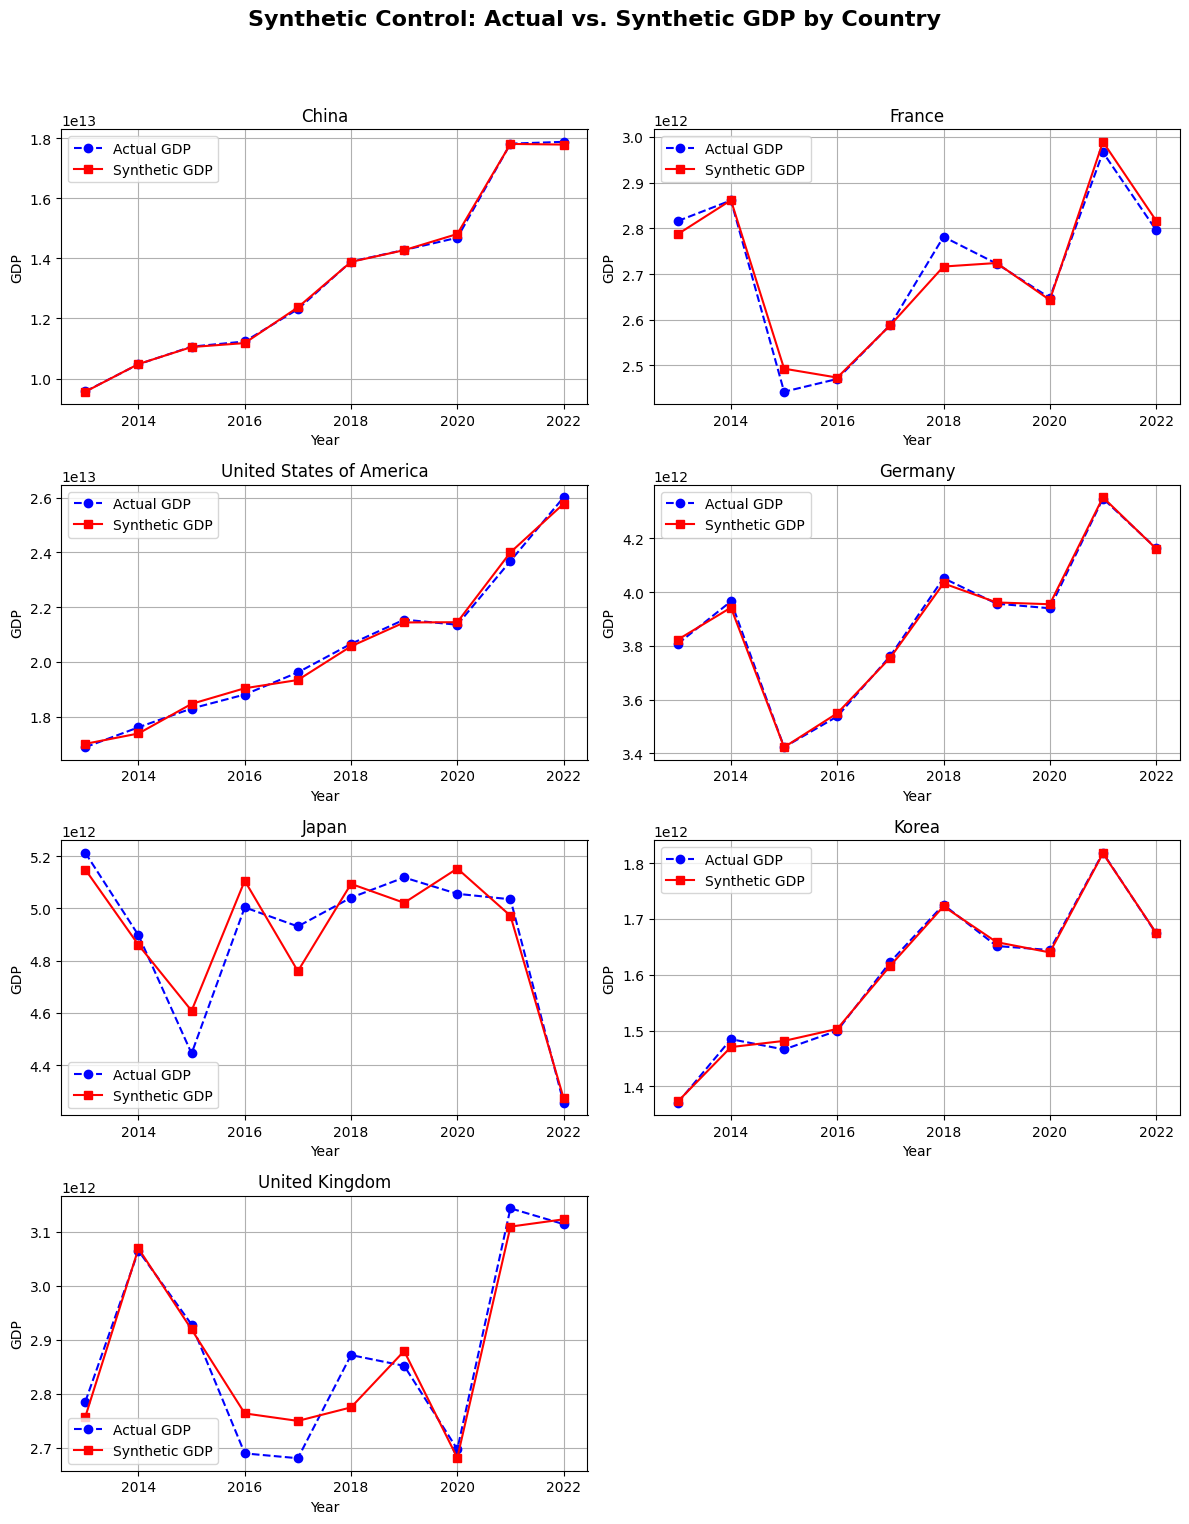

In [ ]:
valid_countries = [country for country, syn in synthetic_results.items() if syn is not None]
num_valid = len(valid_countries)
cols = 2
rows = (num_valid + 1) // cols

fig2, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
fig2.suptitle("Synthetic Control: Actual vs. Synthetic GDP by Country", fontsize=16, fontweight='bold')

# 만약 서브플롯이 1차원 배열이면 2차원 배열로 변환
if rows == 1 and num_valid == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = np.array([axes])

i = 0
for country in valid_countries:
    # 실제 국가의 데이터
    country_data = df[df["Country"] == country].copy()
    if country_data.empty:
        continue
    years_actual = country_data["Year"]
    gdp_actual = country_data["GDP"]
    
    # Synthetic GDP: synthetic_results[country] (예측된 synthetic GDP 배열)
    synthetic_gdp = synthetic_results[country]

    ax = axes[i // cols, i % cols]
    
    # 실제 GDP 선
    ax.plot(years_actual, gdp_actual, label="Actual GDP", linestyle="--", marker="o", color="blue")
    # Synthetic GDP 선
    ax.plot(years_actual, synthetic_gdp, label="Synthetic GDP", linestyle="-", marker="s", color="red")
    
    ax.set_title(f"{country}")
    ax.set_xlabel("Year")
    ax.set_ylabel("GDP")
    ax.legend()
    ax.grid(True)
    
    i += 1

# 빈 서브플롯 제거
if num_valid % cols != 0:
    for j in range(i, rows * cols):
        fig2.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Synthetic Control 결과를 활용한 GDP 차이(증감률) 테이블 생성 및 시각화
- 각 국가별 실제 GDP와 Synthetic GDP 간의 차이(%)를 계산하여 요약 테이블 생성

In [ ]:
difference_summary = []

for country, synthetic_gdp in synthetic_results.items():
    # 해당 국가의 실제 GDP 데이터
    country_data = df[df["Country"] == country].copy()
    if country_data.empty or synthetic_gdp is None:
        continue
    actual_gdp = country_data["GDP"].values
    # Synthetic GDP: Ridge 회귀를 통해 예측한 값
    diff_percent = (synthetic_gdp - actual_gdp) / actual_gdp * 100
    avg_diff = np.mean(diff_percent)
    min_diff = np.min(diff_percent)
    max_diff = np.max(diff_percent)
    difference_summary.append({
        "Country": country,
        "Avg Difference (%)": avg_diff,
        "Min Difference (%)": min_diff,
        "Max Difference (%)": max_diff,
    })

difference_df = pd.DataFrame(difference_summary)
print("\nSynthetic Control: GDP Difference Summary")
print(difference_df.to_string(index=False))


Synthetic Control: GDP Difference Summary
                 Country  Avg Difference (%)  Min Difference (%)  Max Difference (%)
                   China            0.003810           -0.509935            0.851892
                  France            0.021325           -2.340451            2.065571
United States of America            0.013423           -1.406950            1.338385
                 Germany            0.004781           -0.583931            0.402991
                   Japan            0.047894           -3.472211            3.672854
                   Korea            0.007395           -0.951727            1.049615
          United Kingdom            0.036236           -3.376590            2.756094
